In [8]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import os
import transformers
from accelerate import Accelerator

accelerator = Accelerator()
device = accelerator.device

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [9]:
from transformers import ViTImageProcessor, ViTForImageClassification, ViTConfig
from PIL import Image
import requests

# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
url = "http://farm3.staticflickr.com/2066/1798910782_5536af8767_z.jpg"
# url = "http://farm1.staticflickr.com/184/399924547_98e6cef97a_z.jpg"
# url = "http://farm1.staticflickr.com/128/318959350_1a39aae18c_z.jpg"
image = Image.open(requests.get(url, stream=True).raw)

pretrained_name = 'google/vit-base-patch16-224'
config = ViTConfig.from_pretrained(pretrained_name)
processor = ViTImageProcessor.from_pretrained(pretrained_name)
pred_model = ViTForImageClassification.from_pretrained(pretrained_name)
pred_model.to(device)

inputs = processor(images=image, return_tensors="pt")
inputs.to(device)
outputs = pred_model(**inputs, output_hidden_states=True)
logits = outputs.logits
# model predicts one of the 1000 ImageNet classes
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", pred_model.config.id2label[predicted_class_idx])

Predicted class: American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier


In [10]:
import math 

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_blocks=5, bottleneck_dim=64):
        super(MLP, self).__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.layers = nn.ModuleList()
        for _ in range(num_blocks):
            shortcut_layers = []
            shortcut_layers.append(nn.Linear(hidden_dim, bottleneck_dim))
            shortcut_layers.append(nn.Dropout())
            shortcut_layers.append(nn.ReLU())  # Using ReLU for simplicity; you can choose other activations as needed
            shortcut_layers.append(nn.Linear(bottleneck_dim, bottleneck_dim))
            shortcut_layers.append(nn.Dropout())
            shortcut_layers.append(nn.ReLU())
            shortcut_layers.append(nn.Linear(bottleneck_dim, hidden_dim))
            shortcut_layers.append(nn.Dropout())
            self.layers.append(nn.Sequential(*shortcut_layers))

        self.output_layer= nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.input_layer(x)
        for layer in self.layers:
            x = x + layer(x) # shortcut
        return self.output_layer(x)


def pairwise_cosine_similarity(Q, K):
    """
    Q: [N, d]
    K: [N, L, d]
    """
    attention_scores = torch.matmul(K, Q.unsqueeze(-1)).squeeze(-1) #[N, L]

    denominator = (K**2).sum(-1) # [N, L]
    attention_weights = attention_scores / (denominator + 1e-5)
    return attention_weights # [N, L]

class SimplifiedAttention(nn.Module):
    def __init__(self):
        super(SimplifiedAttention, self).__init__()
    
    def forward(self, q, k, v, reduce=False):
        Q = q # [N, d]
        K = k # [N, L, d]
        V = v # [N, L, d]

        attention_weights = pairwise_cosine_similarity(Q, K) # [N,  L]
        attention_outputs = attention_weights.unsqueeze(-1) * V # [N, L, d]
        if reduce:
            attention_outputs = attention_outputs.sum(-2) # [N, d]

        return attention_outputs, attention_weights  # Return both weights and outputs


class SurrogateInterpretation(nn.Module):
    def __init__(self, pred_model, classifier_head, input_embed, hidden_size, config) -> None:
        """
        pred_model: prediction model
        classifier_head: last fully connected layer 
        """
        super().__init__()

        self.pred_model = pred_model

        # Input embedding, it doesn't necessarily be an embedding per se. 
        # It used to convert the input to a form of list of token tensors.
        self.input_embed = input_embed

        # Classifier head
        self.classifier = classifier_head
        # Transform function to non-linearly transform patch embedding to the representation space
        self.encoder = MLP(input_dim=hidden_size,
                                  hidden_dim=hidden_size,
                                  output_dim=hidden_size,
                                  num_blocks=5,
                                  bottleneck_dim=64)
        
        self.attention = SimplifiedAttention()
        
        # Reconstruction head
        self.rec_decoder = nn.Sequential(
            nn.Conv2d(
                in_channels=config.hidden_size,
                out_channels=config.encoder_stride**2 * config.num_channels,
                kernel_size=1,
            ),
            nn.PixelShuffle(config.encoder_stride)
        )

        # freeze parameters of the prediction model.
        if True:
            self.freeze_params()
        
        self.sim_loss_func = nn.MSELoss()
        self.cls_loss_func = nn.CrossEntropyLoss()
        # self.cls_loss_func = nn.NLLLoss()
        self.kl_loss = torch.nn.KLDivLoss(reduction='batchmean', log_target=True)
        self.cossim_loss_func = nn.CosineSimilarity(dim=-1)
    
    def freeze_params(self,):
        for name, param in self.pred_model.named_parameters():
            param.requires_grad = False 
            # print(f"freezed {name}")
        for param in self.classifier.parameters():
            param.requires_grad = False   
        for param in self.input_embed.parameters():
            param.requires_grad = False   
        return 0
    
    def compute_loss(self, pred, pseudo_label, recon_x, x):
        
        # sim_loss = self.sim_loss_func(pred_out, pseudo_label_out)
        cls_loss = self.cls_loss_func(pred, pseudo_label)
        # cls_loss = self.cls_loss_func(torch.log(pred), pseudo_label)
        # kl_loss = self.kl_loss(F.log_softmax(pred_out, dim=-1), F.log_softmax(pseudo_label_out, dim=-1))
        # cos_sim = - self.cossim_loss_func(pred_out, pseudo_label_out).mean()
        rec_loss = self.compute_rec_loss(recon_x, x)

        loss = cls_loss + 1 * rec_loss

        return {'loss':loss, 
                'cls_loss': cls_loss,
                'rec_loss': rec_loss}

    def compute_rec_loss(self, recon_x, x):
        reconstruction_loss = nn.functional.mse_loss(recon_x, x, reduction="mean")
        return reconstruction_loss

    def forward(self, pixel_values, labels=None):
        outputs = self.pred_model(pixel_values=pixel_values, output_hidden_states=True) 
        last_cls_hidden_state = outputs['hidden_states'][-1][:,0,:] # [N, d] the last hidden state of the cls token
        last_cls_hidden_state = pred_model.vit.layernorm(last_cls_hidden_state) # [N, d]
        
        patch_embeddings = self.input_embed(pixel_values=pixel_values) # [N, L, d]

        patch_reprs = self.encoder(patch_embeddings)

        # Get the decomposed interpretable token features
        attention_output_split, attention_weights = self.attention(
            last_cls_hidden_state,
            patch_reprs,
            patch_reprs,
        ) # attention_weight [N, L], attention_output [N, L, d], 
        
        # recover the interpretable features to prediction space and predict.
        attention_output = attention_output_split.sum(-2) # [N, d]
        pred = self.classifier(attention_output)  #[N, 1000]

        # get pseudo labels as ground truth for interpretable surrogate
        pseudo_label_out = torch.softmax(self.classifier(last_cls_hidden_state),dim=-1) # [N, 1000]
        pseudo_label = pseudo_label_out.argmax(-1) # [N,]

        # get reconstructed tokens
        decoded = self.decoder(patch_reprs) # [N, L, d]
        # decoded.permute(0,2,1) # [N, d, L]
        batch_size = pixel_values.shape[0]
        num_channels = decoded.shape[-1]
        height = width = math.floor(decoded.shape[1]**0.5)
        decoded = decoded.permute(0, 2, 1).reshape(batch_size, num_channels, height, width)
        recon_pixel_values = self.rec_decoder(decoded) # [N, 3, H, W]
        

        loss_dict = self.compute_loss(pred, pseudo_label, recon_pixel_values, pixel_values)

        loss = loss_dict['loss']

        pred_labels = pred.argmax(-1).view(-1)
        correct = (pred_labels == pseudo_label).sum()
        accuracy = correct / len(pred_labels)

        if labels is not None:
            pred_accuracy = (pseudo_label == labels).sum() / len(labels)
            outputs['pred_acc'] = pred_accuracy

        outputs['patch_reprs'] = patch_reprs
        outputs['attention_output'] = attention_output
        outputs['attention_output_split'] = attention_output_split
        outputs['last_hidden_state'] = last_cls_hidden_state
        outputs['loss'] = loss
        outputs['rec_loss'] = loss_dict['rec_loss']
        outputs['cls_loss'] = loss_dict['cls_loss']
        outputs['acc'] = accuracy
        outputs['pred'] = pred
        return outputs

In [11]:
from datasets import load_dataset,load_metric

def load_data(): 
    dataset = load_dataset("mrm8488/ImageNet1K-val")
    dataset = dataset['train']
    splits = dataset.train_test_split(test_size=0.1, seed=42)
    test_ds = splits['test']
    splits = splits['train'].train_test_split(test_size=0.1, seed=42)
    train_ds = splits['train']
    val_ds = splits['test']
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = load_data()

Repo card metadata block was not found. Setting CardData to empty.


In [12]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=processor.image_mean, std=processor.image_std)
if "height" in processor.size:
    size = (processor.size["height"], processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in processor.size:
    size = processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = processor.size.get("longest_edge")

train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

In [13]:
from torch.utils.data import DataLoader

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}


batch_size = 512
train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=batch_size, shuffle=True)
batch = next(iter(train_dataloader))
for k, v in batch.items():
    if isinstance(v, torch.Tensor):
        print(k, v.shape)

pixel_values torch.Size([512, 3, 224, 224])
labels torch.Size([512])


In [14]:
input_embed = pred_model.get_input_embeddings()
classifier_head = pred_model.classifier
hidden_size = config.hidden_size
model = SurrogateInterpretation(pred_model=pred_model, classifier_head=classifier_head, input_embed=input_embed, hidden_size=hidden_size, config=config)
model.to(device)
outputs = model(**inputs)
print("attention_output shape: ", outputs['attention_output'].shape)
print("attention_output_split shape: ", outputs['attention_output_split'].shape)
# print("attention_weights shape: ", outputs['attention_weights'].shape)
print("last_hidden_state shape: ", outputs['last_hidden_state'].shape)
print("patch_reprs shape: ", outputs['patch_reprs'].shape)

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

model.train()
for epoch in range(5):
    for idx, data in enumerate(train_dataloader):
        pixel_values = data['pixel_values'].to(device)
        label = data['labels'].to(device)
        outputs = model(pixel_values, label)
        loss = outputs['loss']
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"loss: {loss.item()}, acc: {outputs['acc'].item()}, pred_acc: {outputs['pred_acc'].item()}"
              f"rec_loss: {outputs['rec_loss'].item()}, cls_loss: {outputs['cls_loss'].item()}")

attention_output shape:  torch.Size([1, 768])
attention_output_split shape:  torch.Size([1, 196, 768])
last_hidden_state shape:  torch.Size([1, 768])
patch_reprs shape:  torch.Size([1, 196, 768])
loss: 5.143105983734131, acc: 0.359375, pred_acc: 0.7578125rec_loss: 0.32548782229423523, cls_loss: 4.817618370056152
loss: 10.243721961975098, acc: 0.115234375, pred_acc: 0.75rec_loss: 0.2851009964942932, cls_loss: 9.95862102508545
loss: 8.913293838500977, acc: 0.1171875, pred_acc: 0.76171875rec_loss: 0.2288912832736969, cls_loss: 8.684402465820312
loss: 7.3650007247924805, acc: 0.1953125, pred_acc: 0.751953125rec_loss: 0.12333258241415024, cls_loss: 7.241668224334717
loss: 4.468682289123535, acc: 0.318359375, pred_acc: 0.751953125rec_loss: 0.2387239634990692, cls_loss: 4.229958534240723
loss: 4.696766376495361, acc: 0.2734375, pred_acc: 0.755859375rec_loss: 0.10238504409790039, cls_loss: 4.594381332397461
loss: 4.422811031341553, acc: 0.3203125, pred_acc: 0.76953125rec_loss: 0.11667528748512

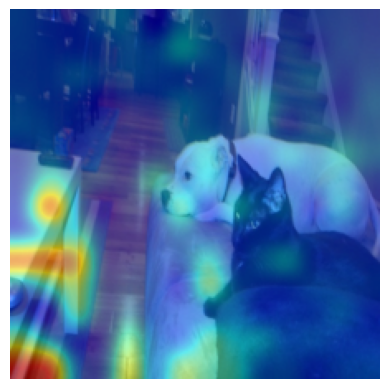

In [17]:
import numpy as np
import cv2
import matplotlib.pyplot as plt 

mean=processor.image_mean
std=processor.image_std

def get_pyx_prime(model, outputs):
    """
    Obtain p(y|x), where x is an individual token of the input
    Args:
        model: a ViT model
        outputs: the outputs of the ViT model given input consists of tokens
    Returns:
        pyx: p(y|x)
    """
    # image_embeds = outputs.hidden_states[-1] # [N, L+1, d]
    image_embeds = outputs['attention_output_split'] # [N, L, d]
    # image_embeds = model.vit.layernorm(image_embeds) # [N, L+1, d]

    logits = model.classifier(image_embeds) # [N, L, 1000]
    pyx = 1

    return pyx, logits

def get_heatmap(pyx, pyx_prime):
    """
    Given p(y|x) and p(y|x'), where x' is the input with the ith entry missing.
    Args:
        pyx: [N, 1, 1000]
        pyx_prime: [N, L, 1000]

    Returns: 
        heatmap: [N, 14, 14, 1000]
    """
    # res = (pyx - pyx_prime) # [N, L, N]
    res = pyx_prime
    N_v, L, N_t = res.shape
    # res = (res>0).float() * res
    
    heatmap = res.reshape(N_v,14,14, N_t).detach().cpu().numpy()
    return heatmap

def unnormalize(img, mean, std):
    mean = np.array(mean).reshape(1,1,3)
    std = np.array(std).reshape(1,1,3)
    return img * std + mean

def convert_to_255_scale(img):
    return (img * 255).astype(np.uint8)

def unnormalize_and_255_scale(img, mean, std):
    return convert_to_255_scale(unnormalize(img,mean,std))

def show_superimposed(img, heatmap):
    cv2_image = cv2.cvtColor(img.transpose(1,2,0), cv2.COLOR_RGB2BGR)
    blur = cv2.GaussianBlur(heatmap,(13,13), 11)

def normalize_and_rescale(heatmap):
    max_value = np.max(heatmap)
    min_value = np.min(heatmap)
    heatmap_ft = (heatmap - min_value) / (max_value - min_value) # float point
    return convert_to_255_scale(heatmap_ft) # int8

def get_overlap(image, heatmap):
    return cv2.addWeighted(heatmap, 0.5, image, 0.5, 0)

def plot_overlap(image, heatmap):
    overlap = get_overlap(image, heatmap)
    plt.imshow(overlap)
    plt.axis('off')
    plt.show()
    return 0

def plot_overlap_np(image, heatmap, img_mean, img_std):
    shape = image.shape[:2]
    heatmap = normalize_and_rescale(heatmap)
    resized_heatmap = cv2.resize(heatmap, shape)
    blur = cv2.blur(resized_heatmap ,(13,13), 11)
    heatmap_img = cv2.applyColorMap(blur, cv2.COLORMAP_JET)
    heatmap_img = cv2.cvtColor(heatmap_img, cv2.COLOR_BGR2RGB)

    image = unnormalize_and_255_scale(image, img_mean, img_std)
    
    plot_overlap(image, heatmap_img)
    return image, heatmap_img

model.eval()
outputs = model(**inputs)
pyx, pyx_prime = get_pyx_prime(model, outputs)
heatmap = get_heatmap(pyx, pyx_prime)[0,:,:,predicted_class_idx]
img = inputs.pixel_values[0].cpu().numpy().transpose(1,2,0)

image, heatmap_img = plot_overlap_np(img, heatmap, mean, std)
# print(pyx_prime)

In [16]:
outputs['attention_output_split'].shape        

torch.Size([1, 196, 768])